In [1]:


import cv2
import hoho
import matplotlib.pyplot as plt
import numpy as np

hoho.LOCAL_DATADIR = hoho.setup("../data")
from handcrafted_solution import predict
from tqdm import tqdm

Using ..\data as the data directory (we are running locally)


In [2]:
# split = "val"
split = "train"

dataset = hoho.get_dataset(decode=None, split=split)
import webdataset as wds

# targets = wds.WebDataset("../data/val/targets/hoho_v3_025-of-032.tar.gz")
targets = dataset

In [4]:
solution = []
for i, sample in tqdm(enumerate(dataset)):
    # print(sample)
    # break
    #if i > 170:
    key, pred_vertices, pred_edges = predict(sample, visualize=False, point_radius=40, max_angle=5, extend=30,)
    solution.append({
        '__key__': key,
        'wf_vertices': pred_vertices.tolist(),
        'wf_edges': pred_edges
    })

2it [00:06,  3.48s/it]


KeyboardInterrupt: 

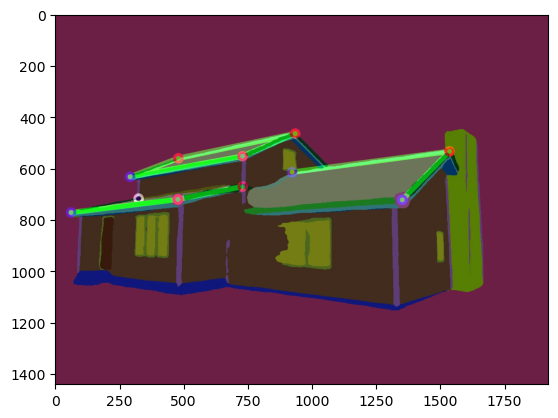

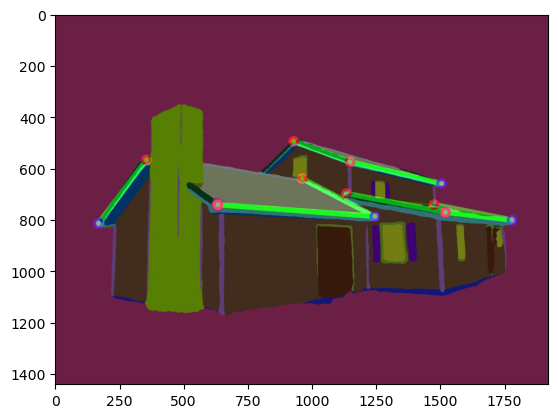

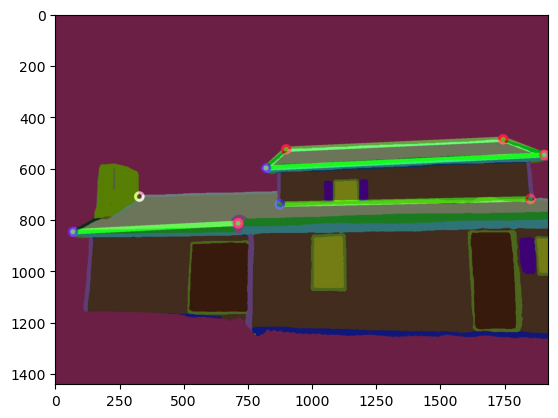

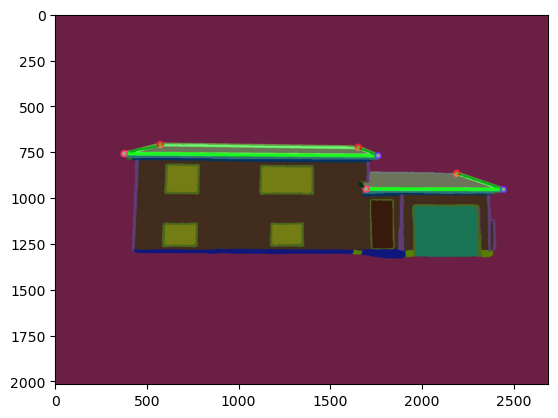

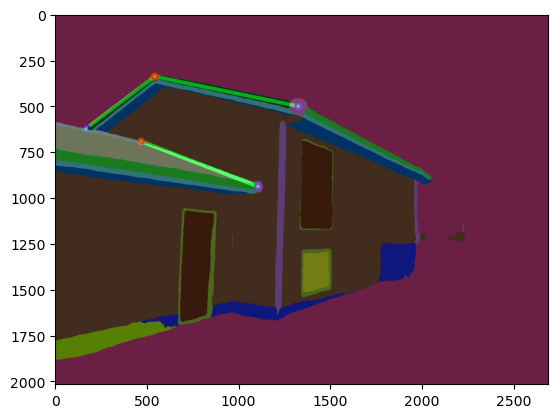

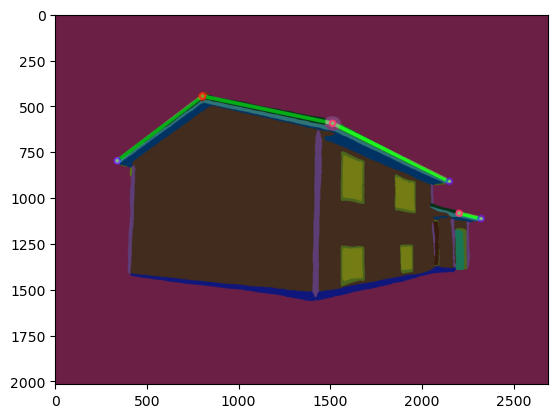

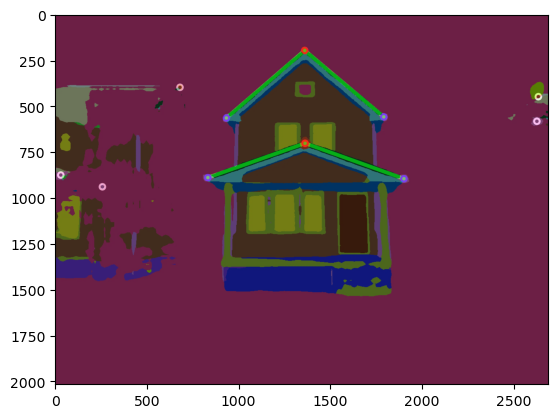

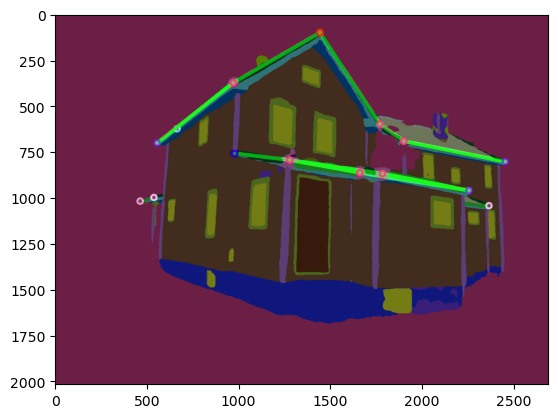

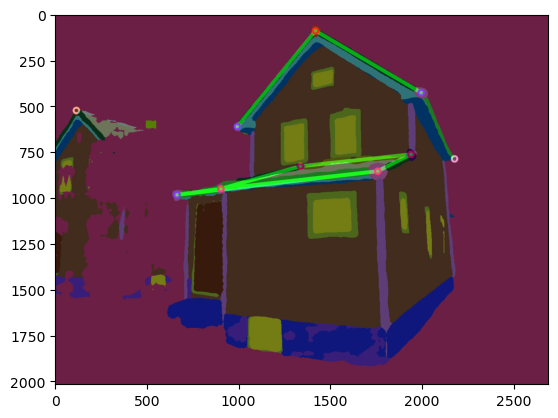

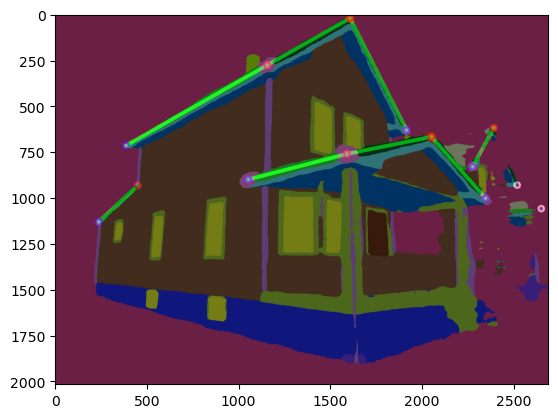

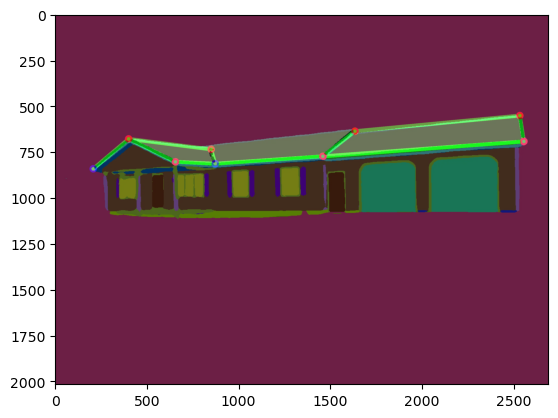

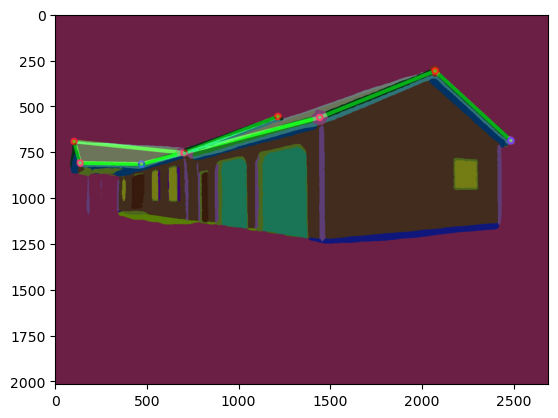

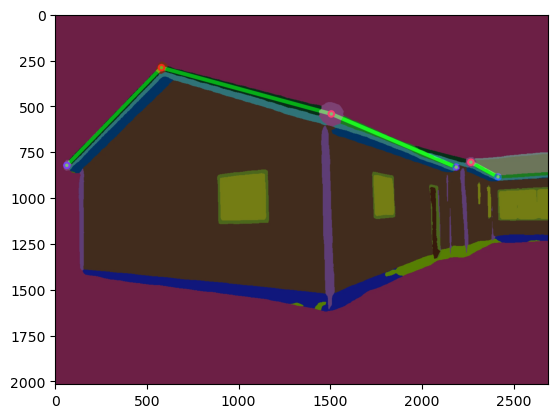

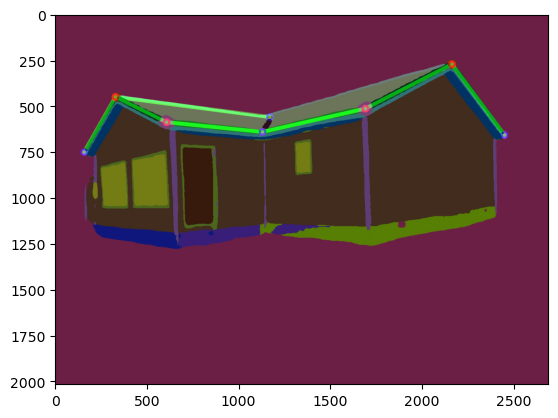

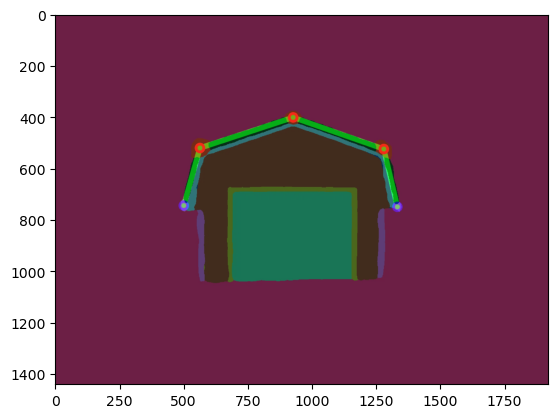

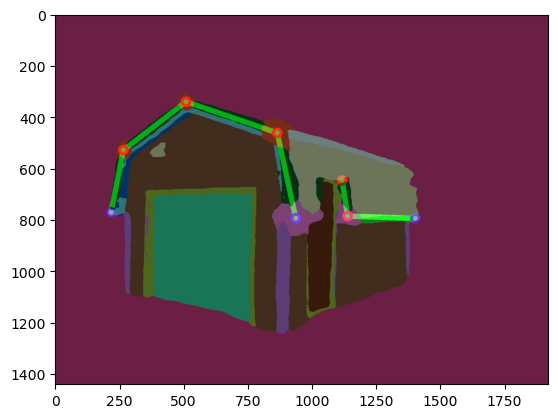

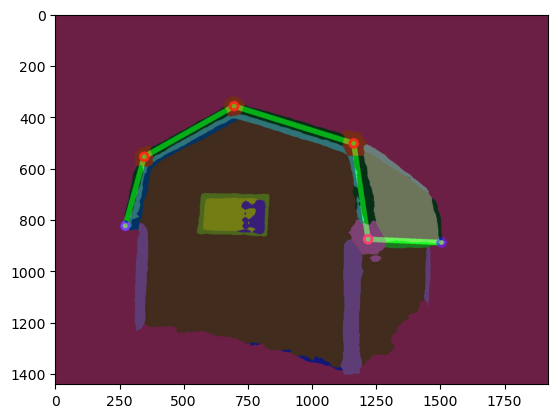

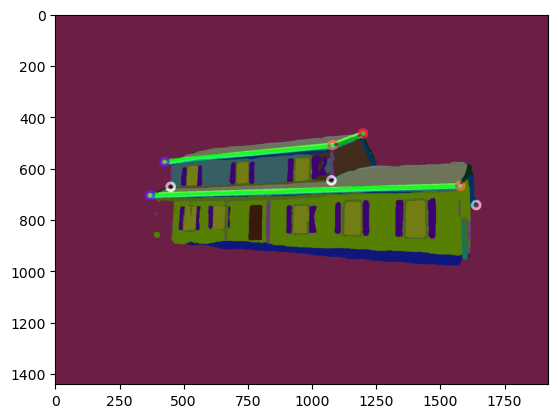

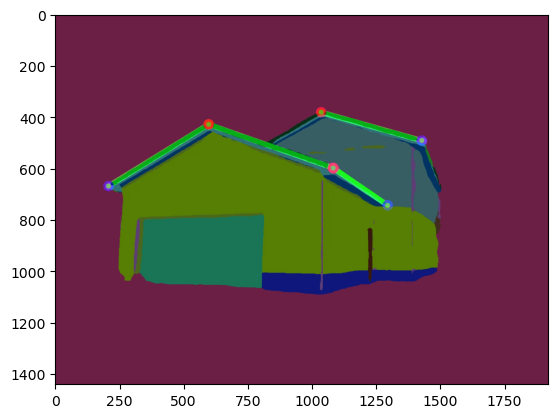

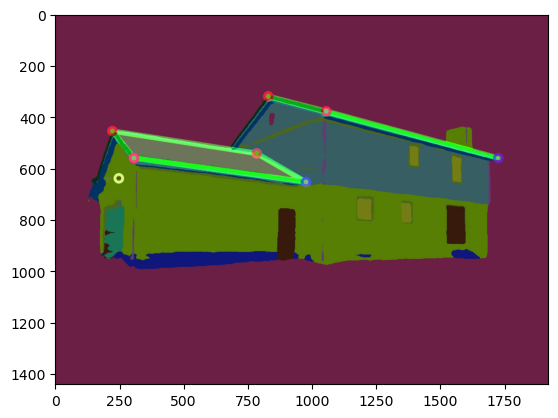

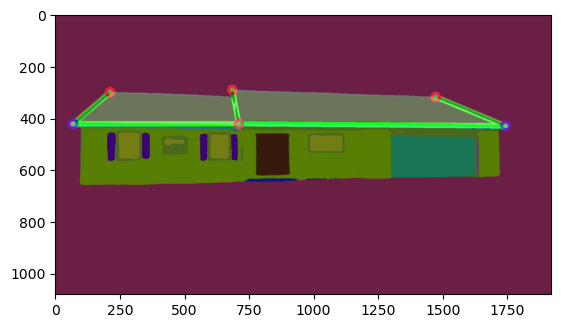

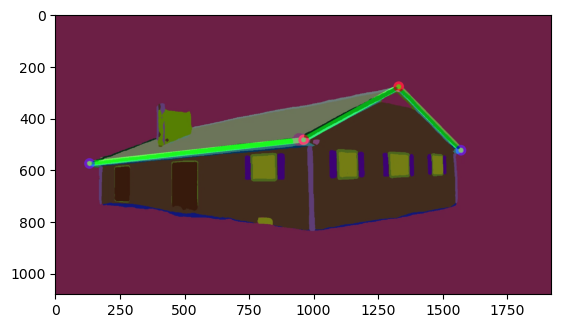

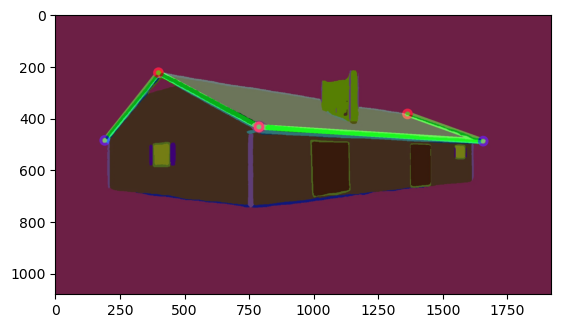

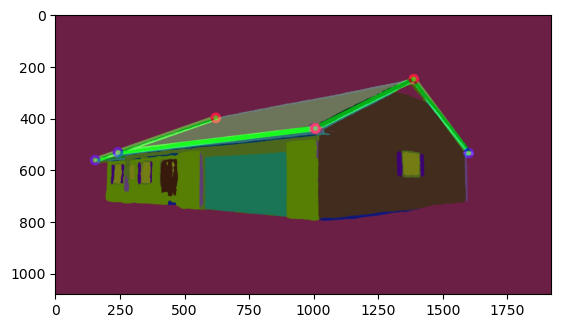

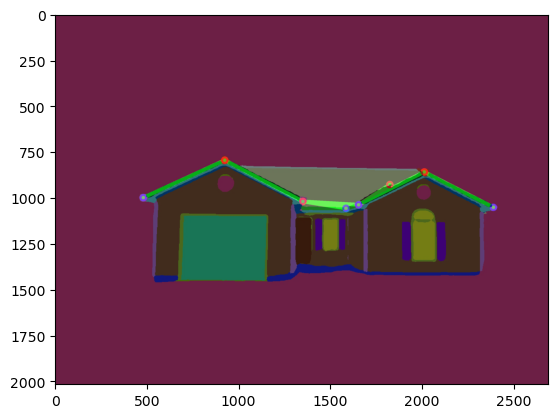

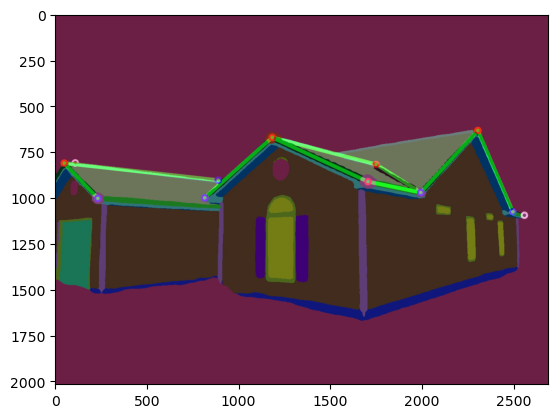

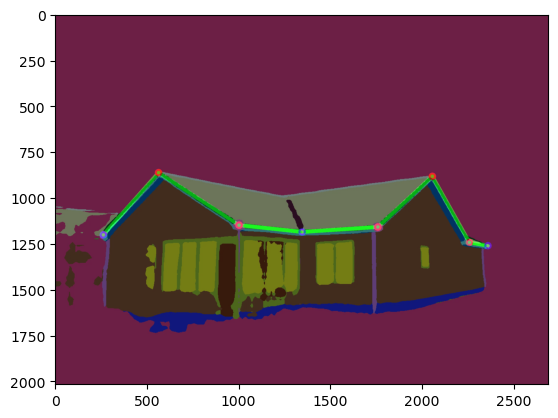

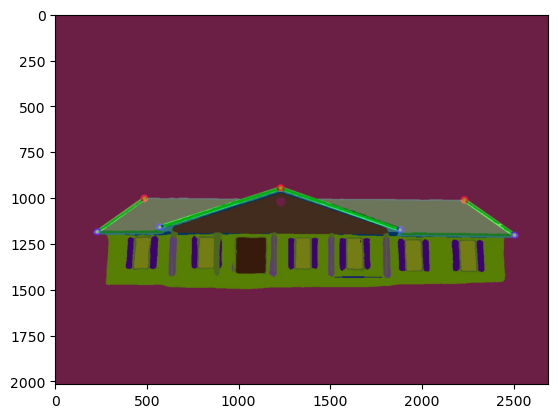

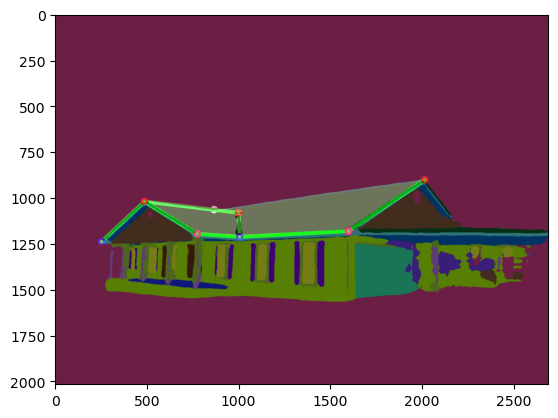

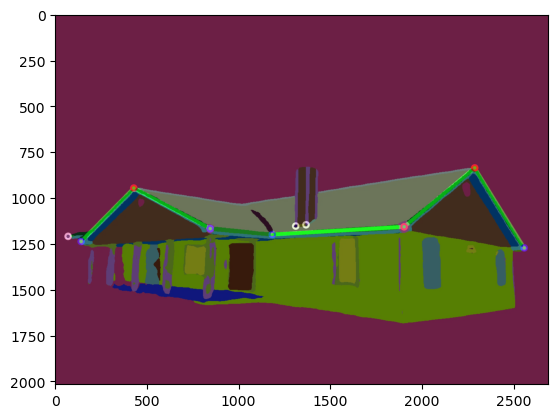

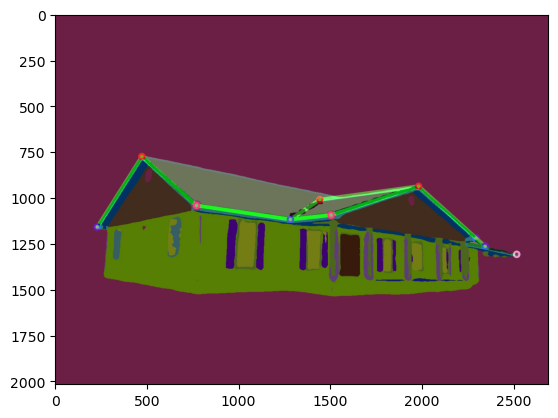

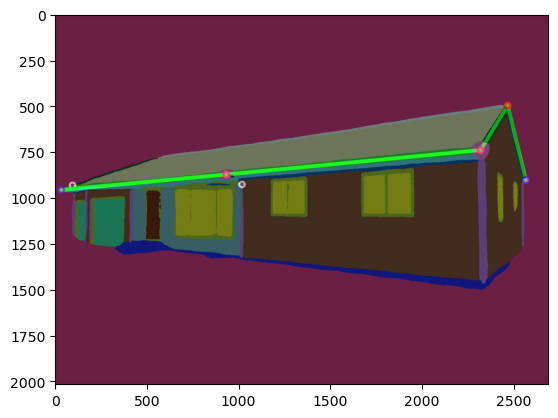

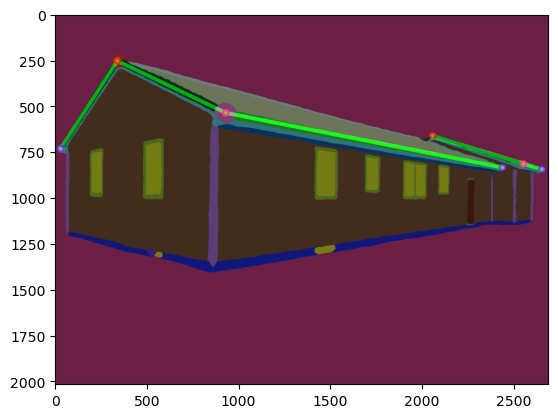

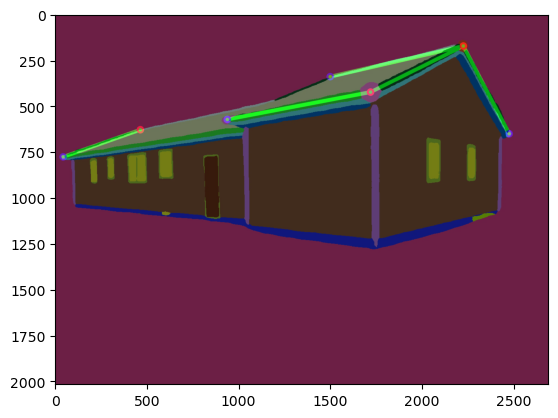

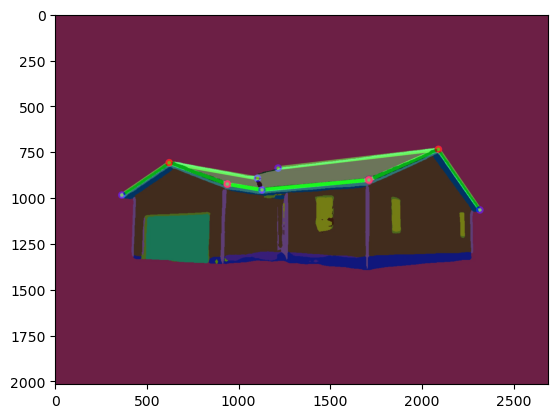

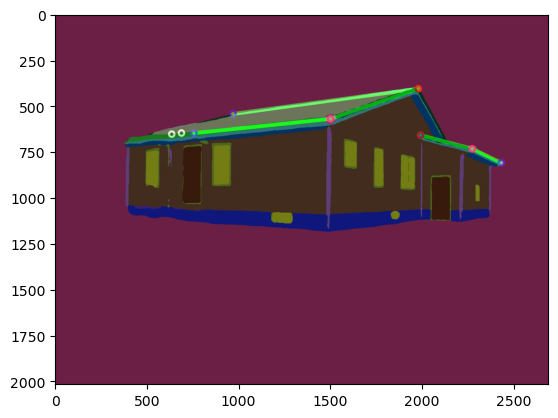

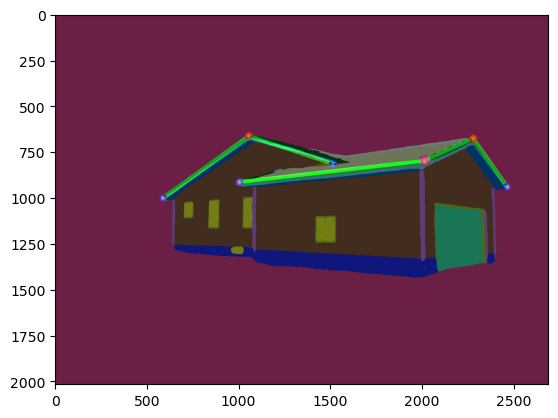

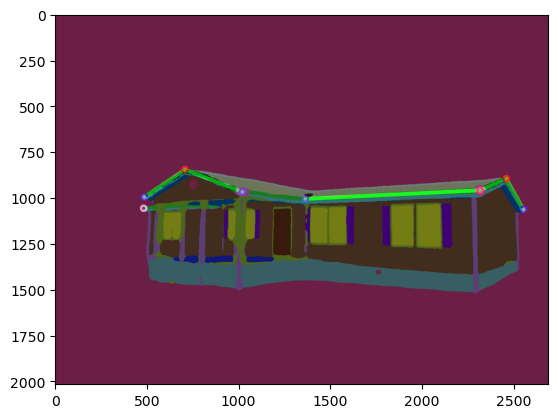

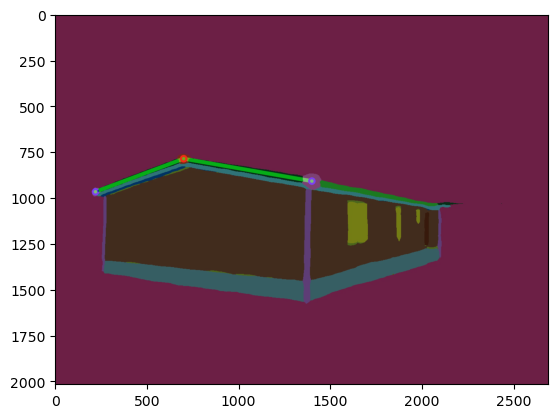

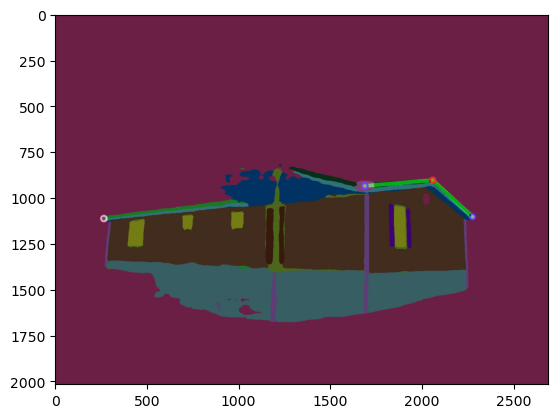

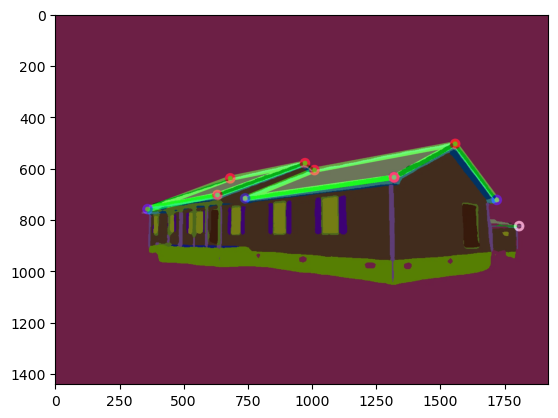

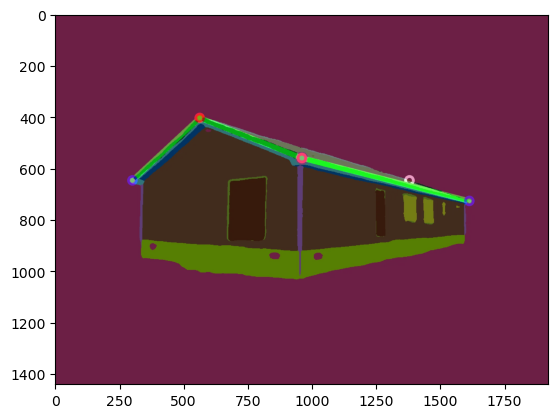

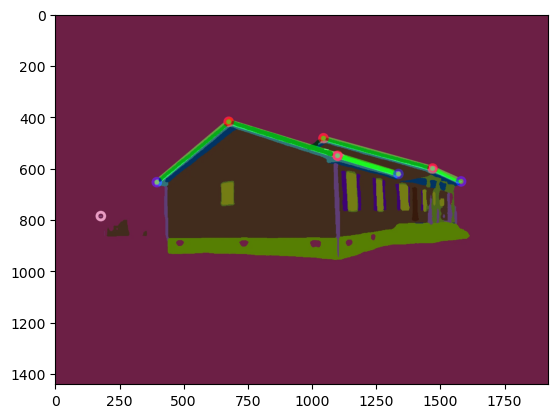

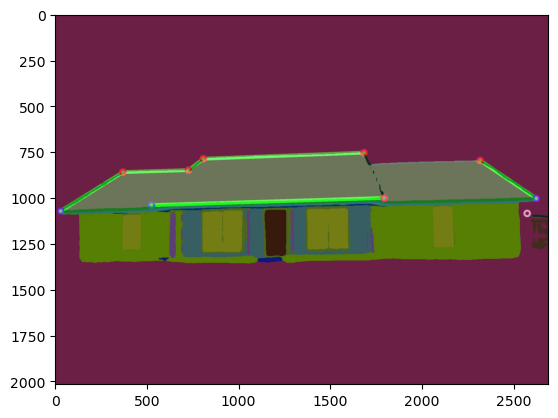

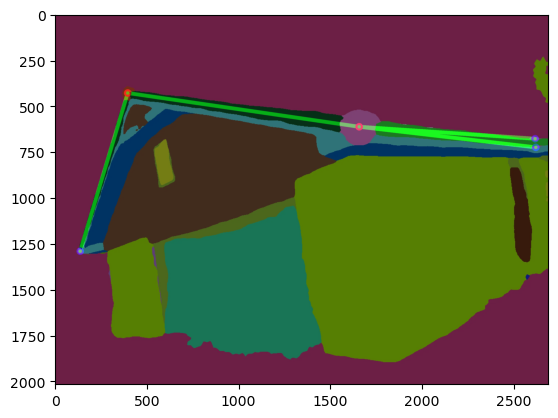

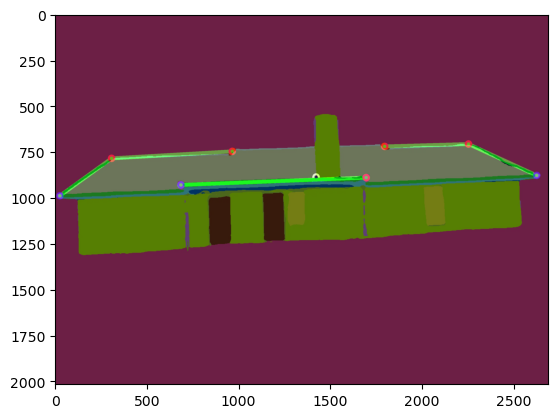

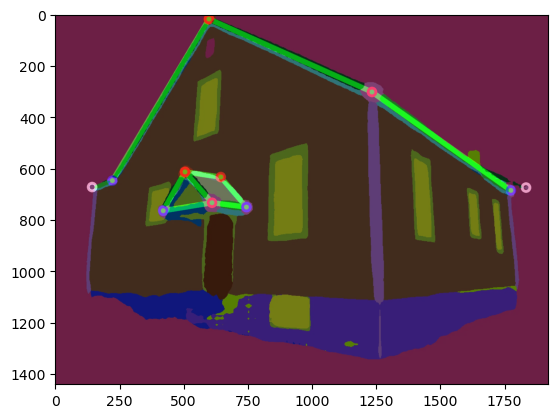

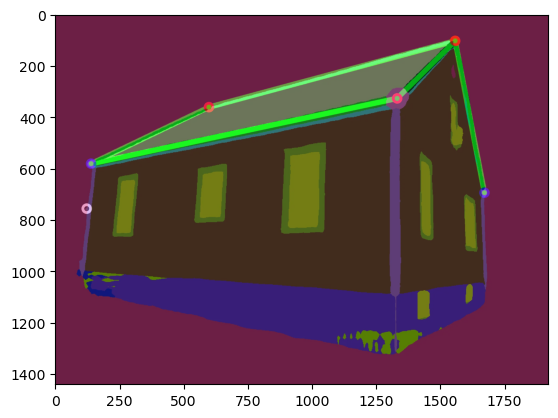

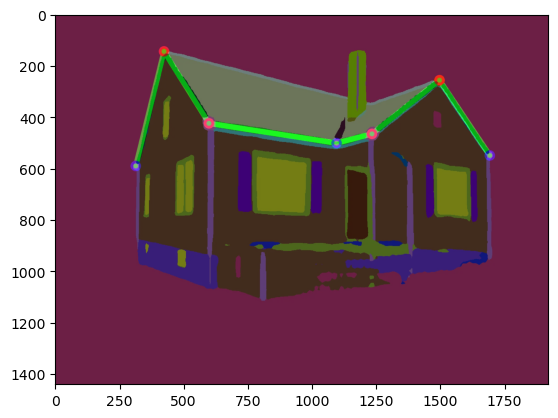

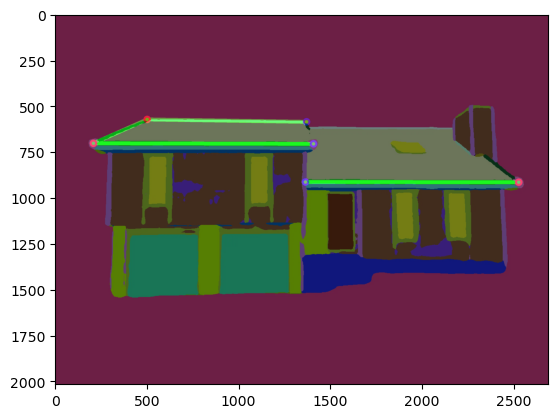

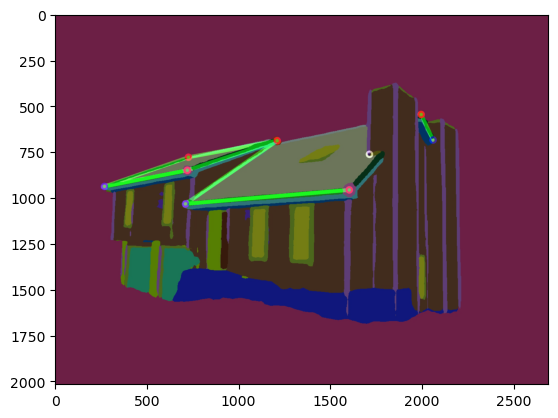

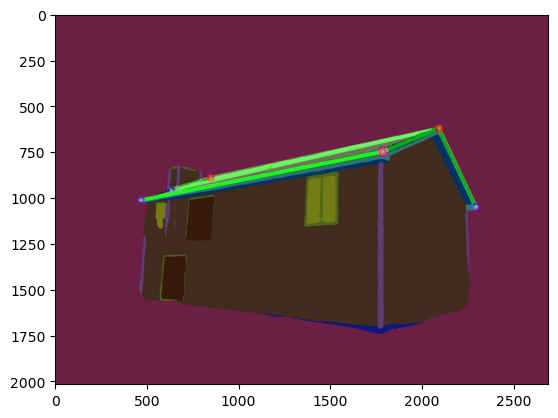

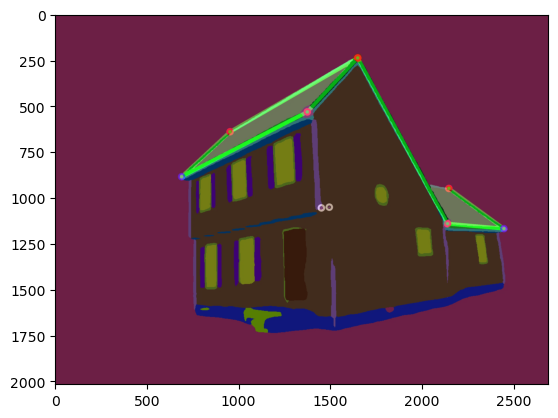

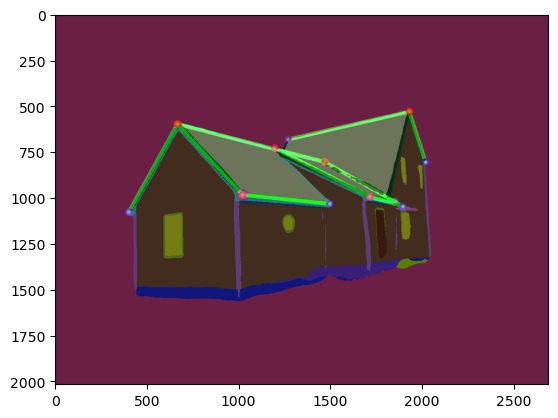

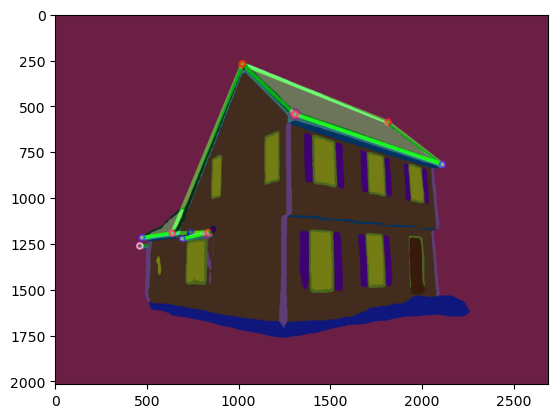

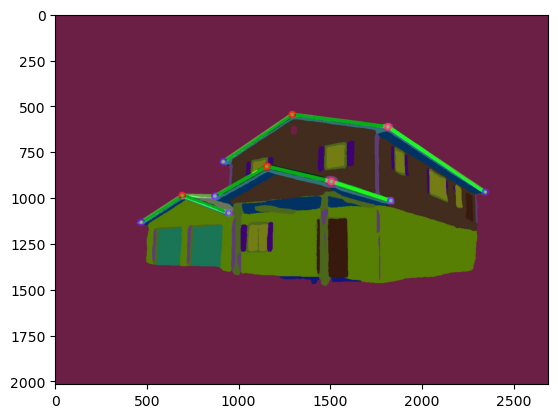

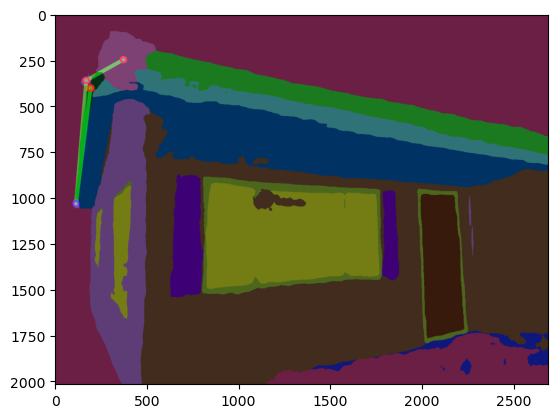

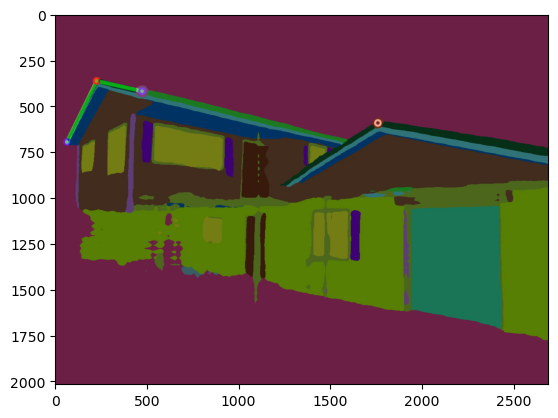

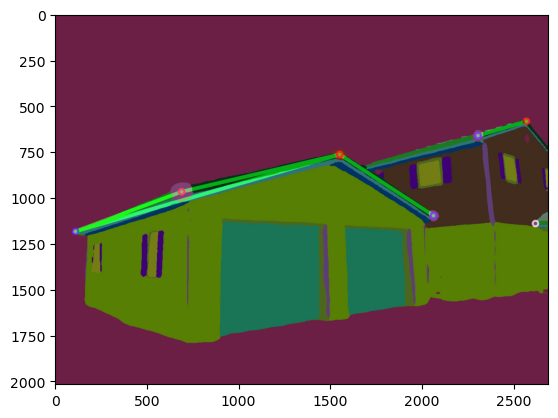

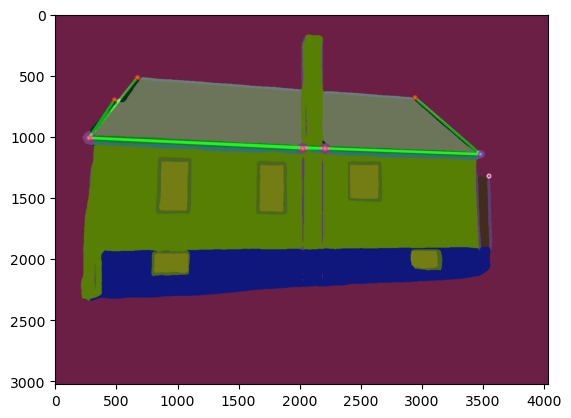

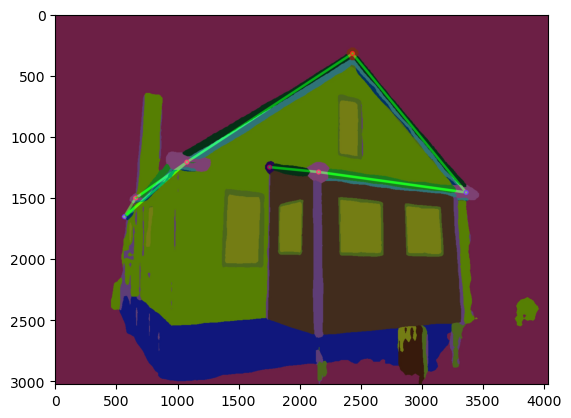

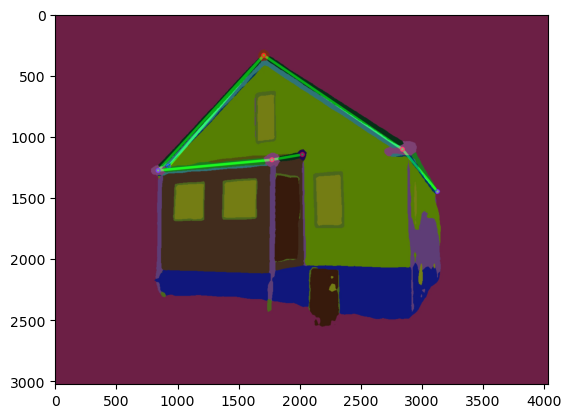

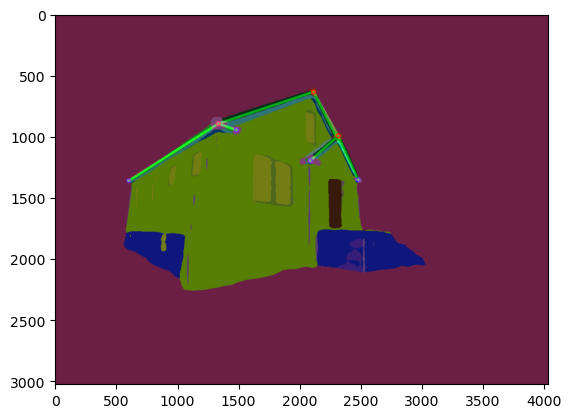

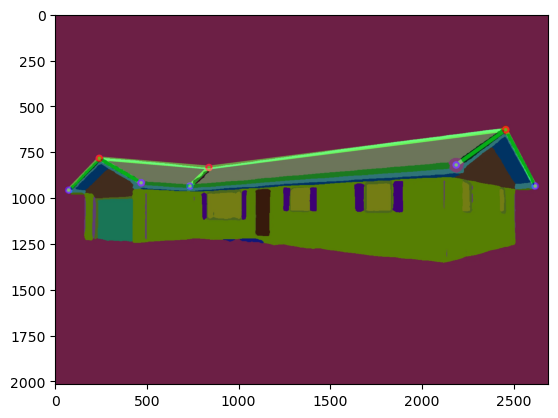

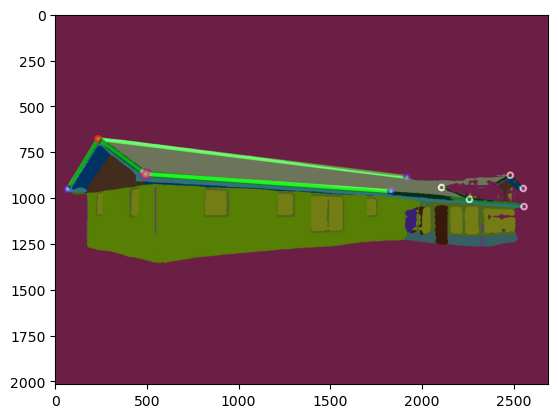

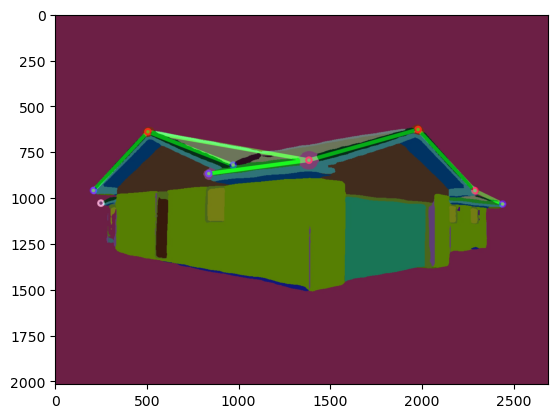

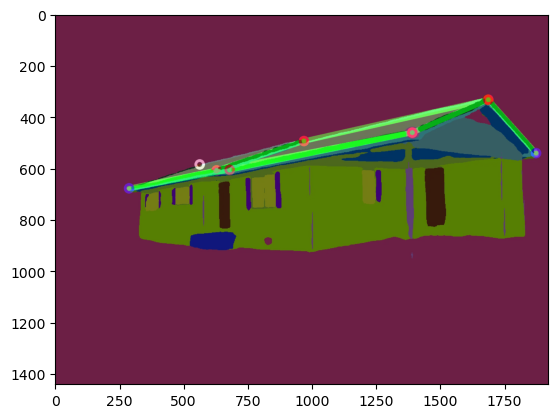

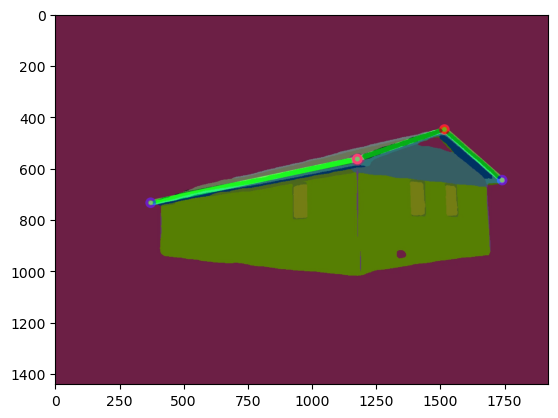

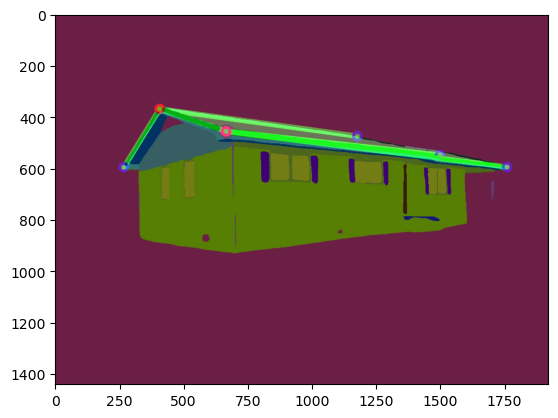

In [3]:
from handcrafted_solution import get_vertices_and_edges_from_segmentation
for entry_idx, entry in enumerate(dataset):
    if entry_idx > 20:
        break
    
    entry = hoho.decode(entry)
    
    vert_edge_per_image = {}
    
    
    for i, (gest, depthcm, K, R, t, imagekey) in enumerate(zip(entry['gestalt'],
                                                               entry['depthcm'],
                                                               entry['K'],
                                                               entry['R'],
                                                               entry['t'],
                                                               entry['__imagekey__']
                                                               )):
    
        gest_seg = gest.resize(depthcm.size)
        gest_seg_np = np.array(gest_seg).astype(np.uint8)
        vertices, connections = get_vertices_and_edges_from_segmentation(gest_seg_np,                                        
                                                                         point_radius=30,
                                                                         max_angle=10,
                                                                         extend=50,
                                                                         merge_th=80.0,
                                                                         min_missing_distance=1000.0,
                                                                         scale_estimation_coefficient=2.54,
                                                                         clustering_eps=150,
                                                                         interpolation_radius=10000,
                                                                         point_radius_scale=1,
                                                                         # dist_coeff=0,
                                                                         pointcloud_depth_coeff=1.005,)
        vertices = np.array([v["xy"] for v in vertices])
        lines = np.zeros_like(gest_seg_np)
        for v in vertices:
            cv2.circle(lines, v.astype(np.uint32), 15, (255, 255, 255), 10, -1)
        for i,j in connections:
            cv2.line(lines, vertices[i].astype(np.uint32), vertices[j].astype(np.uint32), (0, 255, 0), 20)
            cv2.circle(lines, vertices[i].astype(np.uint32), 15, (255, 0, 0), 10, -1)
            cv2.circle(lines, vertices[j].astype(np.uint32),15, (0, 0, 255), 10, -1)
        plt.imshow(gest_seg_np)
        plt.imshow(lines, alpha=0.5)
        plt.show()

In [4]:
solution = []
from concurrent.futures import ProcessPoolExecutor
import itertools

# Define batch size
batch_size = 24  # You can adjust this according to your needs

# Define a generator function to yield batches of samples
def batch_generator(dataset, batch_size):
    batch = []
    for i, sample in enumerate(dataset):
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:  # Yield the remaining samples
        yield batch

n_batches = 4
count = 0
# Use the generator to process batches of samples
with ProcessPoolExecutor(max_workers=10) as pool:
    for batch in tqdm(batch_generator(dataset, batch_size), desc='Batches'):
        if count == n_batches:
            break
        count += 1
        results = []
        for i, sample in enumerate(batch):
            results.append(pool.submit(predict, sample,
                                       point_radius=30,
                                       max_angle=5,
                                       extend=30,
                                       merge_th=80.0,
                                       min_missing_distance=1000.0,
                                       scale_estimation_coefficient=2.54,
                                       clustering_eps=150,
                                       interpolation_radius=10000,
                                       point_radius_scale=1,
                                       # dist_coeff=0,
                                       pointcloud_depth_coeff=1,
                                       ))

        for result in tqdm(results, desc='Results', total=len(results), position=0):
            key, pred_vertices, pred_edges = result.result()
            solution.append({
                '__key__': key,
                'wf_vertices': pred_vertices.tolist(),
                'wf_edges': pred_edges
            })

Results: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s]
Batches: 4it [01:35, 23.95s/it]


In [5]:
import io

solution_dict = {}
for d in solution[:batch_size*n_batches]:
    solution_dict[d["__key__"]] = d
# for d in solution[173:]:
#     solution_dict[d["__key__"]] =S {"wf_vertices":[[0,100,0], [0,-100,0], [100,0,0], [-100,0,0]], "wf_edges": [(0, 2), (2, 1), (1, 3), (3, 0)]}
WEDs = []

for idx, i in enumerate(targets):
    if idx > 96:
        break
    try:
        j = solution_dict[i["__key__"]]
        # i = dict(np.load(io.BytesIO(i["wireframe.npz"])))
        WEDs.append(hoho.compute_WED(j["wf_vertices"], j["wf_edges"], i["wf_vertices"], i["wf_edges"]))
    except KeyError:    
        pass

import scipy.stats as ss

ss.describe(WEDs)

DescribeResult(nobs=96, minmax=(1.029156185412059, 3.0528145132609468), mean=1.899641154248861, variance=0.1677105828693464, skewness=0.5407619334375078, kurtosis=-0.06305215517105145)

In [11]:
WEDs

[2.0495589945251753,
 2.3375091064229823,
 2.54587118745223,
 1.7936889981248856,
 1.6305386225970389,
 2.5030365365123046,
 2.5341427910856726,
 1.6196122684825838,
 2.3106909417188177,
 2.1379248420764627,
 1.4455052101141632,
 2.383858692255746,
 1.9526994019165556,
 2.5370678442943575,
 2.4544279568424496,
 2.778705713230045,
 1.8225131568078652,
 2.4875468506520035,
 2.3175946890178882,
 2.0986692679400303,
 2.1380252803309325,
 2.5114265209029774,
 2.0692824931533176,
 1.7393626980563632,
 2.921543121207442,
 2.5780823604599337,
 2.39661742191219,
 2.573468701635433,
 2.0796429993752525,
 2.0986129025612565,
 2.0197442222588293,
 3.290127982858006,
 1.6114840381135243,
 1.8145726737442316,
 2.0368268680986126,
 1.8839614369223336,
 2.779980365966191,
 2.5595653281800588,
 2.823900715465502,
 2.6700098263430916,
 2.2679795118569,
 1.747554515594796,
 1.4587536374110048,
 1.9501367057935086,
 1.7083421727010308,
 2.2474571106553256,
 1.8844788149560738,
 1.7635817282765678,
 2.3606

In [6]:
solution

[{'__key__': '3848f53011f',
  'wf_vertices': [[-851.927131705015, -14.77837399317582, 385.36426511628764],
   [-362.26609349970465, 164.50304094953356, 373.06809041325477],
   [-382.88447760208226, 399.36105999219365, 387.027454225875],
   [-389.4219372374505, 401.89041480444575, 297.1626629565235],
   [-891.7867726558522, 426.66971419006154, 223.8552679215727],
   [-352.5933239263061, 584.3507807791209, 248.86913316632968],
   [-352.0417951071081, -116.16129242900013, 372.1908739699769],
   [-358.8844214423292, -328.9086534862489, 391.78162061226647],
   [-340.5671216622602, -295.26248439559356, 300.7533074353697],
   [-872.0856994315245, -402.020513113132, 223.46728879167983],
   [361.59359080727654, -254.09258166359984, 311.87817970880957],
   [-275.69888033636266, -574.1345452785782, 222.5840600635466],
   [-328.11123916119595, -386.7368893547324, 223.0083051577143],
   [492.200837542023, -14.530346470915674, 538.2170783672323],
   [485.30044001067216, -239.48091932641637, 303.2432

best  mean=1.767499469714739

                                       point_radius=45,
                                       max_angle=4,
                                       extend=25,
                                       merge_th=80.0,
                                       min_missing_distance=1000.0,
                                       scale_estimation_coefficient=2.54,
                                       clustering_eps=150,
                                       interpolation_radius=10000,
                                       point_radius_scale=0.5,
                                       # dist_coeff=0,
                                       pointcloud_depth_coeff=1.005,
                                       
removed blur
decreased number of dilations to 2
decreased kernel size to 11
decreased color range to 3.5
moved vertice stop condition after inferring the missing vertices
added mean interpolation k = 2

In [5]:
WEDs

[2.186387396483042,
 1.9458889786731612,
 1.534071340092823,
 2.2108385238415367,
 2.1631415629382778,
 0.7882253044055504,
 1.8429855191829267,
 2.335507827368746,
 1.6458120956725337,
 2.0313304734198225,
 1.3280295466320697,
 1.6249505091073895,
 2.745113683523396,
 1.6844059473700304,
 2.2109143797897883,
 2.5510577241659202,
 1.523864391611916,
 2.4887000887687067,
 1.573480042896035,
 1.8632995914320063,
 1.7998482602068953,
 1.9460490933336407,
 2.0297686469393668,
 1.3721439076004947,
 1.482771856701213,
 2.4354673204851984,
 1.5583352581598928,
 1.411868865934151,
 1.5949406516134628,
 1.4247320838071649,
 1.8172080406854545,
 2.4780335897939216,
 1.358234734993022,
 2.083767066409992,
 1.6347032173433291,
 2.908487889445689,
 2.3445127696039023,
 1.8661841771306553,
 1.4077556790018204,
 2.096999302323779,
 2.218852497529648,
 1.766143540097659,
 2.08181307184284,
 1.3292550023837104,
 2.266341471995852,
 2.4511813616512854,
 1.514863936968505,
 2.1965575941157254,
 1.3642283

In [33]:
from handcrafted_solution import convert_entry_to_human_readable, get_vertices_and_edges_from_segmentation

In [38]:
from hoho import color_mappings

3it [00:00, 16.18it/s]

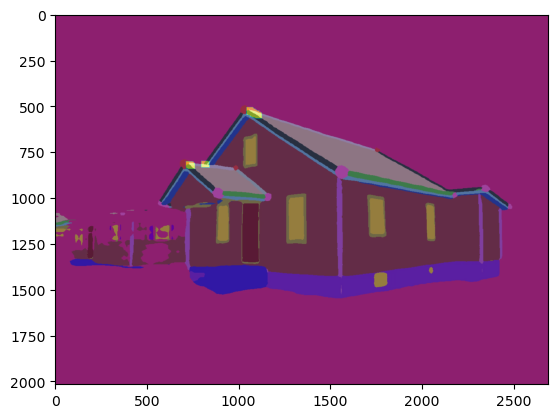

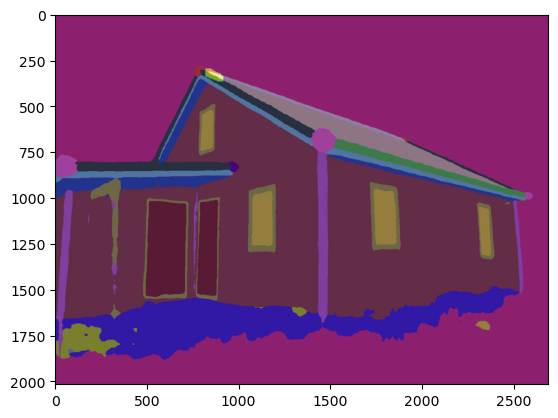

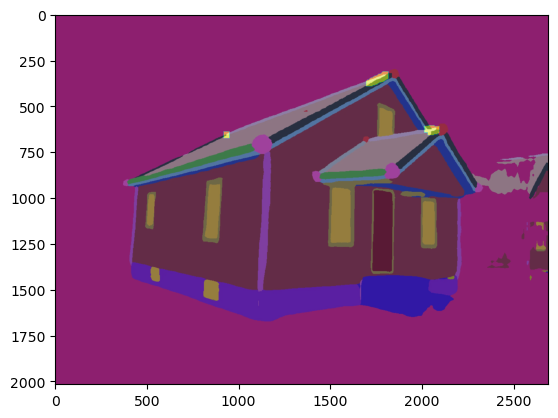

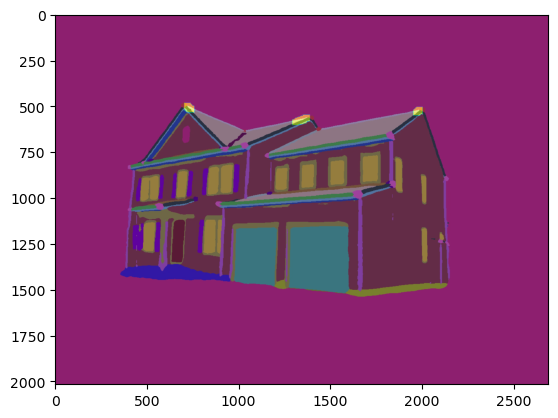

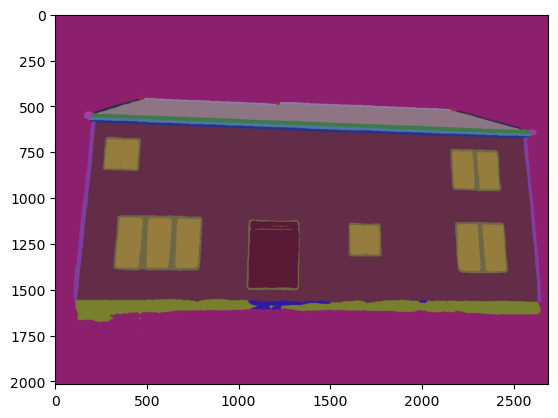

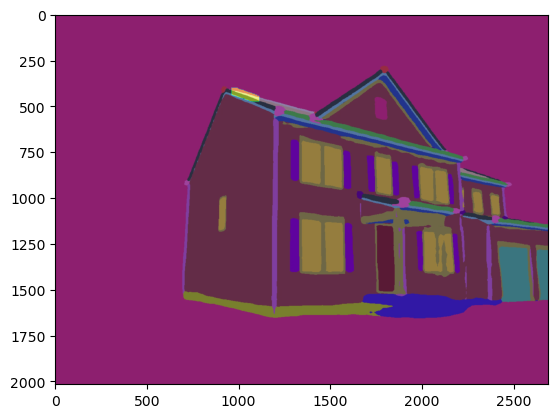

7it [00:05,  1.19it/s]

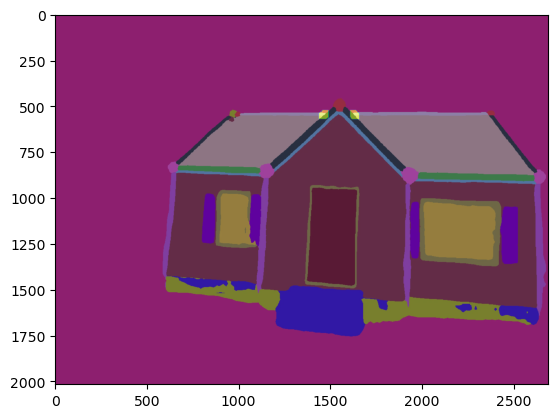

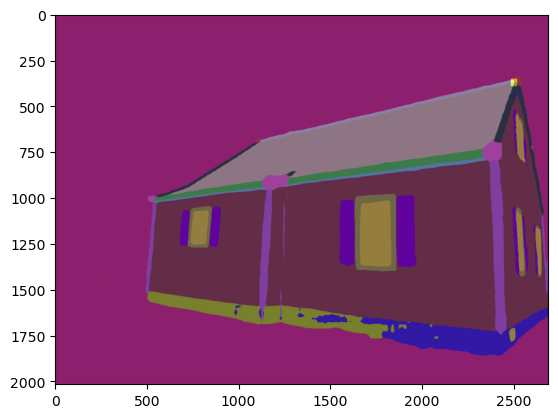

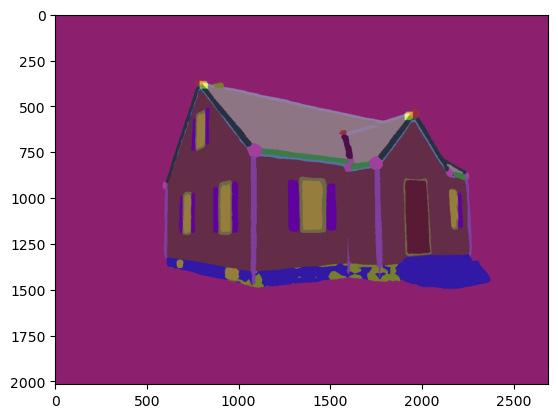

33it [00:09, 13.13it/s]

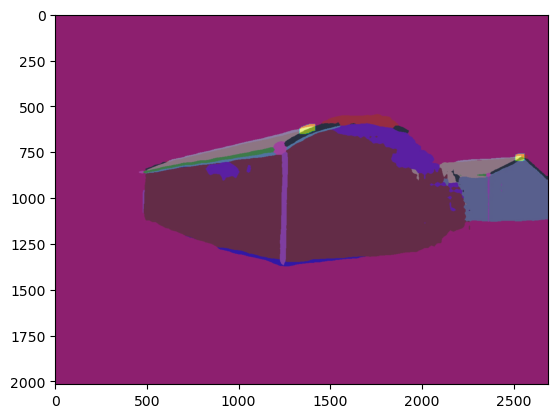

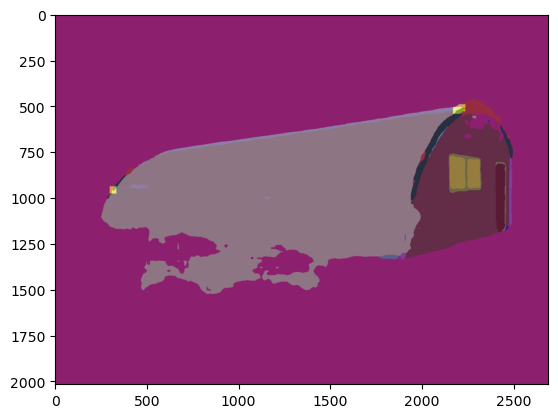

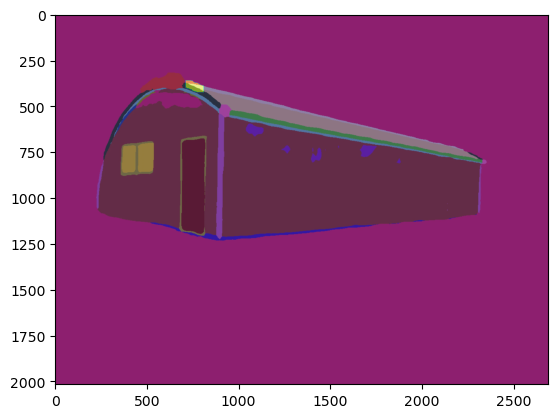

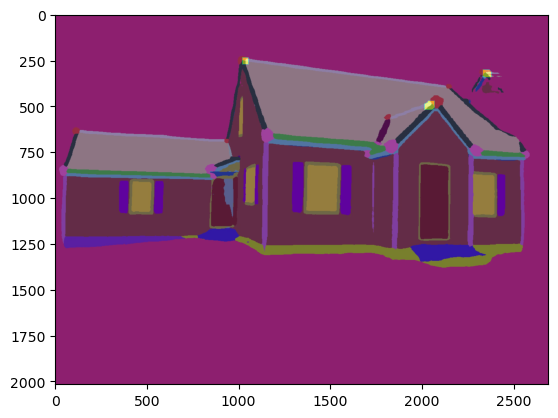

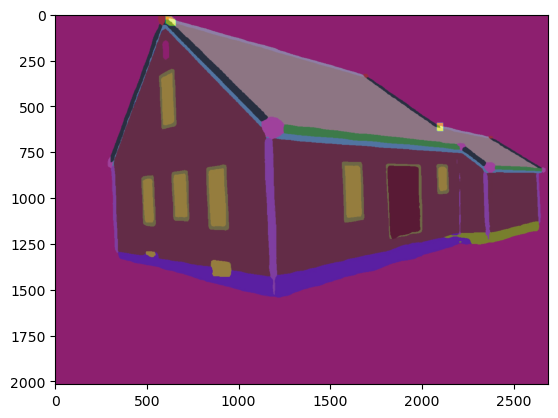

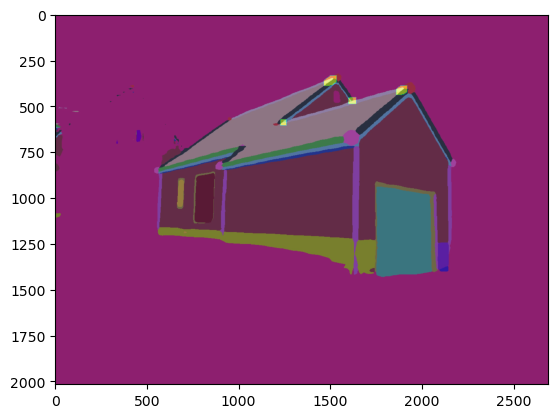

346it [00:18, 18.58it/s] 


In [49]:
color_range = 4.
indices = set(np.where(np.array(WEDs) > 3)[0][:5])
for i, sample in tqdm(enumerate(dataset)):
    if i in (indices):
        sample = convert_entry_to_human_readable(sample)
        for gestalt, ade20k in zip(sample["gestalt"], sample["ade20k"]):
            gestalt = np.array(gestalt)
            ridge_mask = cv2.inRange(gestalt,
                                     np.array(color_mappings.gestalt_color_mapping["ridge"]) - color_range,
                                     np.array(color_mappings.gestalt_color_mapping["ridge"]) + color_range)
            ridge_mask = cv2.morphologyEx(ridge_mask,
                                          cv2.MORPH_DILATE, np.ones((3, 3)), iterations=4)
            rake_mask = cv2.inRange(gestalt,
                                    np.array(color_mappings.gestalt_color_mapping["rake"]) - color_range,
                                    np.array(color_mappings.gestalt_color_mapping["rake"]) + color_range)
            rake_mask = cv2.morphologyEx(rake_mask,
                                         cv2.MORPH_DILATE, np.ones((3, 3)), iterations=4)

            intersection_mask = cv2.bitwise_and(ridge_mask, rake_mask)
            intersection_mask = cv2.morphologyEx(intersection_mask, cv2.MORPH_DILATE, np.ones((11, 11)), iterations=3)

            plt.imshow(gestalt)
            plt.imshow(intersection_mask, alpha=0.5)
            plt.show()
# if i > 170:
# predict(sample, visualize=True, point_radius=40, max_angle=5)

(array([ 6., 12., 24., 37., 35., 17., 23., 10.,  6.,  3.]),
 array([1.2885549 , 1.54589969, 1.80324448, 2.06058926, 2.31793405,
        2.57527884, 2.83262362, 3.08996841, 3.34731319, 3.60465798,
        3.86200277]),
 <BarContainer object of 10 artists>)

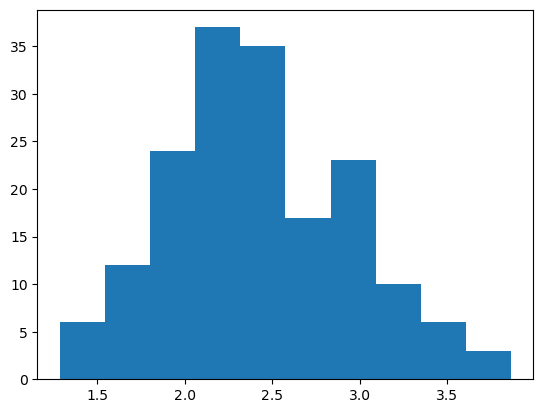

In [24]:
plt.hist(WEDs)

In [80]:
WEDs

[2.2229805695077083,
 1.9514464996164573,
 1.7590658149651095,
 3.1405426461515633,
 2.8183054907145473,
 1.140120966164992,
 2.1558598709479813,
 3.3662869370814827,
 2.3891611651819735,
 2.275638964174794,
 2.1483604574233124,
 2.628918854537702,
 3.1136525432670066,
 2.1715716989266127,
 2.438280253712535,
 2.653076550893886,
 1.9852997999356443,
 2.644463567775789,
 2.2122967796132564,
 2.3063106133427045,
 2.518780917419762,
 2.173287036879083,
 2.5362215037708,
 2.0293073338156344,
 2.1645267490995206,
 2.3771093706013082,
 2.693419063975656,
 2.131319438324366,
 1.803577113450096,
 2.170475125298135,
 2.837187660790624,
 2.902589943407295,
 2.749964377946793,
 2.8058926261061226,
 2.958089603803645,
 3.243547730539942,
 3.4913308530124443,
 1.987038402928909,
 2.0877151308757904,
 2.067962649465477,
 2.747934312119973,
 2.801020542277625,
 2.1139353030967962,
 2.301493743300777,
 2.195098303241758,
 2.1529734033032097,
 1.5749234936721188,
 1.5727846791999307,
 1.519615355101089

[{'__key__': 'ac398eacc02',
  'wf_vertices': [[-656.7050599672618, -605.098754169388, 243.92722906250577],
   [-270.3944092135496, -517.9822255731817, 269.22916207140025],
   [-179.18750033628248, -1394.6868022716815, 374.49496362478897],
   [-487.79387210297637, -1263.613806359354, 285.6131299095989],
   [-825.5136601675167, -954.9844714789193, 203.81423465216574],
   [-872.5067983535567, -1016.2934509036636, 84.66995230858376],
   [255.8133866747114, -1346.719177970111, 412.91042389741824],
   [485.9028287150579, -1531.3825528818056, 138.89326089772047],
   [1567.9935647986138, 559.751036081686, 100.23215302448351],
   [1415.6798411145587, 566.6877693497729, 99.32366541890012],
   [1545.8014993390966, 437.66785057025766, 139.58939347759275],
   [1516.716302070865, 561.7094174542095, 107.84276299884189],
   [1510.6712398820182, 804.3431414136203, 117.81207290756922],
   [1518.4102006603268, 731.4309845567738, 105.0991532914263],
   [1335.6419936963762, 805.8892733753611, 78.6334695275

# grid search

In [9]:
wed_stats = {}

for radius in range(10, 50, 5):
    for angle in range(1, 10):
        for extend in range(0, 40, 10):
            solution = []

            with ProcessPoolExecutor(max_workers=12) as pool:
                results = []
                for i, sample in enumerate(tqdm(dataset)):
                    results.append(pool.submit(predict, sample, visualize=False, point_radius=radius, max_angle=angle,
                                               extend=extend))

                for i, result in enumerate(tqdm(results)):
                    key, pred_vertices, pred_edges = result.result()
                    solution.append({
                        '__key__': key,
                        'wf_vertices': pred_vertices.tolist(),
                        'wf_edges': pred_edges
                    })

            solution_dict = {}
            for d in solution[:173]:
                solution_dict[d["__key__"]] = d
            WEDs = []

            for i in targets:
                try:
                    j = solution_dict[i["__key__"]]
                    i = dict(np.load(io.BytesIO(i["wireframe.npz"])))
                    WEDs.append(hoho.compute_WED(j["wf_vertices"], j["wf_edges"], i["wf_vertices"], i["wf_edges"]))
                except KeyError:
                    pass

            wed_stats[(radius, angle, extend)] = ss.describe(WEDs)

100%|██████████| 346/346 [01:16<00:00,  4.50it/s]
346it [00:11, 29.01it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.62it/s]
346it [00:11, 29.20it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.66it/s]
346it [00:11, 29.43it/s] 
100%|██████████| 346/346 [01:16<00:00,  4.54it/s]
346it [00:12, 28.72it/s] 
100%|██████████| 346/346 [01:14<00:00,  4.64it/s]
346it [00:11, 29.44it/s] 
100%|██████████| 346/346 [01:18<00:00,  4.43it/s]
346it [00:11, 29.12it/s] 
100%|██████████| 346/346 [01:18<00:00,  4.40it/s]


In [10]:
print(wed_stats)

{(10, 1, 0): DescribeResult(nobs=173, minmax=(0.9504744679463277, 4.2688324308036), mean=2.918631217038793, variance=0.2655104551963414, skewness=-0.5301066567004962, kurtosis=0.6648724709751717), (10, 1, 10): DescribeResult(nobs=173, minmax=(1.217735384196255, 4.095658947639928), mean=2.756003469399469, variance=0.28989047602798246, skewness=-0.2945369702420912, kurtosis=-0.02369081827086239), (10, 1, 20): DescribeResult(nobs=173, minmax=(1.1905609076446098, 3.832138275353508), mean=2.7507068339662806, variance=0.25787775042947936, skewness=-0.37508484769566325, kurtosis=-0.03210901516830633), (10, 1, 30): DescribeResult(nobs=173, minmax=(1.7501416446074862, 4.191259803191946), mean=2.961261234054409, variance=0.2398959796022379, skewness=-0.1092311580556235, kurtosis=-0.26051346232955686), (10, 2, 0): DescribeResult(nobs=173, minmax=(0.9504744679463277, 4.128352337180152), mean=2.9003120200331316, variance=0.261910349388631, skewness=-0.5119892469577535, kurtosis=0.6424781625590157),

In [24]:
min_mean_idx = np.argmin([i.mean for i in wed_stats.values()])
min_mean_idx

143

In [29]:
list(wed_stats.keys())[min_mean_idx]

(25, 9, 30)

In [34]:
len(wed_stats)

288

In [12]:
import pickle

In [37]:
with open("27-03-24_08_41_gridsearch.pkl", "wb") as f:
    pickle.dump(wed_stats, f)

In [4]:
with open("27-03-24_08_41_gridsearch.pkl", "rb") as f:
    wed_stats = pickle.load(f)

In [7]:
sorted(wed_stats.items(), key=lambda x: x[1].mean)

[((25, 9, 30),
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.6427458988029624), mean=2.365431389151285, variance=0.24408016546768208, skewness=0.24970843688533947, kurtosis=-0.47489943956804215)),
 ((25, 3, 30),
  DescribeResult(nobs=173, minmax=(1.3277926313096529, 3.5793431626907006), mean=2.365799431760512, variance=0.2283485251258321, skewness=0.14581362181613933, kurtosis=-0.4966945138162737)),
 ((25, 8, 20),
  DescribeResult(nobs=173, minmax=(1.3347463232592418, 3.7489880220512433), mean=2.3666799964968566, variance=0.23256287638977155, skewness=0.2351978824288662, kurtosis=-0.34650790205426807)),
 ((25, 4, 30),
  DescribeResult(nobs=173, minmax=(1.3277926313096529, 3.5559859764406214), mean=2.367685477902936, variance=0.22928262970110813, skewness=0.1234810295855286, kurtosis=-0.6546653426007194)),
 ((35, 2, 10),
  DescribeResult(nobs=173, minmax=(1.3880417275094599, 3.7195088150342186), mean=2.3681322155779267, variance=0.2347349275743601, skewness=0.2734479351216136

In [11]:
wed_stats = {}

for merge_th in range(1, 50, 5):
    solution = []
    merge_th = merge_th * 0.1
    print("merge_th: ", merge_th)
    with ProcessPoolExecutor(max_workers=12) as pool:
        results = []
        for i, sample in enumerate(tqdm(dataset)):
            results.append(pool.submit(predict, sample, visualize=False, point_radius=25, max_angle=15, extend=30,
                                       merge_th=merge_th))

        for i, result in enumerate(tqdm(results)):
            key, pred_vertices, pred_edges = result.result()
            solution.append({
                '__key__': key,
                'wf_vertices': pred_vertices.tolist(),
                'wf_edges': pred_edges
            })

    solution_dict = {}
    for d in solution[:173]:
        solution_dict[d["__key__"]] = d
    WEDs = []

    for i in targets:
        try:
            j = solution_dict[i["__key__"]]
            i = dict(np.load(io.BytesIO(i["wireframe.npz"])))
            WEDs.append(hoho.compute_WED(j["wf_vertices"], j["wf_edges"], i["wf_vertices"], i["wf_edges"]))
        except KeyError:
            pass

    wed_stats[merge_th] = ss.describe(WEDs)

merge_th:  0.1


346it [00:11, 29.29it/s] 
100%|██████████| 346/346 [01:30<00:00,  3.81it/s]


merge_th:  0.6000000000000001


346it [00:11, 30.06it/s] 
100%|██████████| 346/346 [01:29<00:00,  3.88it/s]


merge_th:  1.1


346it [00:12, 28.21it/s] 
100%|██████████| 346/346 [01:28<00:00,  3.92it/s]


merge_th:  1.6


346it [00:12, 28.47it/s] 
100%|██████████| 346/346 [01:27<00:00,  3.94it/s]


merge_th:  2.1


346it [00:12, 26.90it/s] 
100%|██████████| 346/346 [01:28<00:00,  3.92it/s]


merge_th:  2.6


346it [00:11, 29.23it/s] 
100%|██████████| 346/346 [01:27<00:00,  3.98it/s]


merge_th:  3.1


346it [00:11, 28.91it/s] 
100%|██████████| 346/346 [01:30<00:00,  3.83it/s]


merge_th:  3.6


346it [00:11, 28.93it/s] 
100%|██████████| 346/346 [01:34<00:00,  3.68it/s]


merge_th:  4.1000000000000005


346it [00:11, 29.65it/s] 
100%|██████████| 346/346 [01:30<00:00,  3.80it/s]


merge_th:  4.6000000000000005


346it [00:11, 29.16it/s] 
100%|██████████| 346/346 [01:34<00:00,  3.65it/s]


In [13]:
with open("30-03-24_19_00_gridsearch.pkl", "wb") as f:
    pickle.dump(wed_stats, f)

In [17]:
wed_stats

{0.1: DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956),
 0.6000000000000001: DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956),
 1.1: DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956),
 1.6: DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956),
 2.1: DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956),
 2.6:

In [14]:
sorted(wed_stats.items(), key=lambda x: x[1].mean)

[(0.1,
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956)),
 (0.6000000000000001,
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956)),
 (1.1,
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956)),
 (1.6,
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.35790560125656956)),
 (2.1,
  DescribeResult(nobs=173, minmax=(1.3076459810782375, 3.711955004608544), mean=2.3875919110882218, variance=0.24435959160468504, skewness=0.23662307954617326, kurtosis=-0.357905